In [1]:
# default_exp preprocess.input_fields

# Preprocess Inputs

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [3]:
#export
import os
import pickle

import numpy as np 
from scipy.spatial.distance import cdist

import accelerate_simulations
from accelerate_simulations.geometry import GeometryRasterizer, element_to_tag

In [4]:
#hide
path_project = os.path.join(os.getcwd(), '..', "..")
path_data = os.path.join(path_project, "examples", 'box_w_aggr', 'data', 'raw', '1', 'abstract_geometry.pickle')

In [5]:
#hide
with open(path_data, 'rb') as file:
    abstract_geometry = pickle.load(file)

In [6]:
abstract_geometry.box_size

(100, 100)

In [7]:
#hide
rasterize = GeometryRasterizer(resolution=(400, 400))
raster_array = rasterize(abstract_geometry)

In [8]:
#hide
element_to_tag

{'circles': 1, 'box_wo_circles': 2, 'circles_boundaries': 3}

## material

In [9]:
material_properties = {
    "y": {
        "circles": 10,
        "circles_boundaries": 10,
        "box_wo_circles": 1
    },
    "b": {
        "circles": 100,
        "circles_boundaries": 100,
        "box_wo_circles": 100
    }
}

In [10]:
class MaterialFieldMaker:
    def __init__(self, material_properties, element_to_tag):
        self.material_properties = material_properties
        self.element_to_tag = element_to_tag

    def __call__(self, raster_array):
        raster_image = np.array(raster_array.tags)

        material_fields = []
        for _, material_property in self.material_properties.items():
            material_fields.append(
                self._make_field(raster_image, material_property)
            )

        return np.stack(material_fields, axis=-1)

    def _make_field(self, raster_image, material_property):
        material_field = np.zeros_like(raster_image)
        for name, value in material_property.items():
            tag = self.element_to_tag[name]
            cond = (raster_image == tag)
            material_field[cond] = value
        
        return material_field

In [11]:
make_material_fields = MaterialFieldMaker(material_properties, element_to_tag)
material_fields = make_material_fields(raster_array)
material_fields.shape

(400, 400, 2)

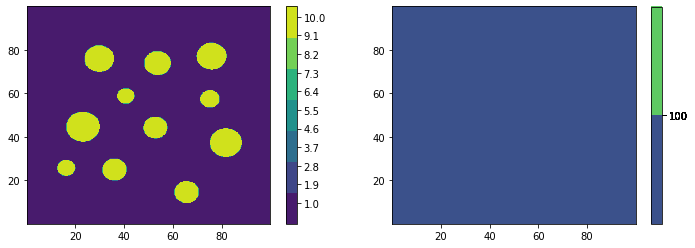

In [12]:
fig = plt.figure(figsize=(12, 4))

for i in range(material_fields.shape[2]):
    grid_x, grid_y = np.meshgrid(raster_array.x, raster_array.y)
    material_field = material_fields[:, :, i]

    plt.subplot(1, 2, i+1)
    plt.contourf(grid_x, grid_y, material_field)
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(material_field.min(), material_field.max(), 11))

## geometry

In [13]:
element_to_tag

{'circles': 1, 'box_wo_circles': 2, 'circles_boundaries': 3}

In [14]:
#export
class GeometricFieldMaker:
    def __init__(self, names_boundary, element_to_tag, scaling_factor):
        self.element_to_tag = element_to_tag
        self.scaling_factor = scaling_factor
        self.names_boundary = self._add_default_boundaries(names_boundary)

    def __call__(self, raster_array):
        raster_image = np.array(raster_array.tags)
        x, y = np.array(raster_array.x), np.array(raster_array.y)
        grid_flat = self._get_grid(x, y)

        geometric_fields = []
        for name in self.names_boundary:
            if name.startswith('default_'):
                grid_flat_some = self._get_grid_default(raster_image, x, y, name)
            else:
                grid_flat_some = self._get_grid_tag(raster_image, x, y, name)

            geometric_field = self._make_geometric_field(grid_flat, grid_flat_some, x, y)
            geometric_fields.append(geometric_field)
        
        return np.stack(geometric_fields, axis=-1)

    @staticmethod
    def _add_default_boundaries(names_boundary):
        names_default_boundary = ['default_left', 'default_bottom', 'default_right', 'default_top']
        names_boundary += names_default_boundary
        return names_boundary

    def _get_default_grid():
        pass 
    
    @staticmethod
    def _get_grid(x, y):
        grid_x, grid_y = np.meshgrid(x, y)
        grid_flat = np.hstack([grid_x.flatten()[:, None], grid_y.flatten()[:, None]])
        return grid_flat

    def _get_grid_tag(self, raster_image, x, y, name):
        tag = self.element_to_tag[name]
        grid_x, grid_y = np.meshgrid(x, y)

        cond = (raster_image==tag)
        grid_x = grid_x[cond]
        grid_y = grid_y[cond]

        return np.hstack([grid_x.flatten()[:, None], grid_y.flatten()[:, None]])

    def _get_grid_default(self, raster_image, x, y, name: str):
        grid_x, grid_y = np.meshgrid(x, y)

        if name.endswith('left'):     grid_x, grid_y = grid_x[0, :], grid_y[0, :]
        elif name.endswith('bottom'): grid_x, grid_y = grid_x[:, 0], grid_y[:, 0]
        elif name.endswith('right'):  grid_x, grid_y = grid_x[-1, :], grid_y[-1, :]
        elif name.endswith('top'):    grid_x, grid_y = grid_x[:, -1], grid_y[:, -1]

        return np.hstack([grid_x.flatten()[:, None], grid_y.flatten()[:, None]])

    def _dist_radial(self, x):
        return np.exp(-self.scaling_factor * x/(x.max()+1e-8))

    def _make_geometric_field(self, grid_flat, grid_flat_some, x, y):
        dist_point_to_boundary = cdist(grid_flat, grid_flat_some)
        dist_point_to_boundary = np.min(dist_point_to_boundary, axis=1)
        geometric_field = self._dist_radial(dist_point_to_boundary)
        return geometric_field.reshape(len(x), len(y))

In [15]:
names_boundary = ['circles_boundaries']

make_geometric_fields = GeometricFieldMaker(names_boundary, element_to_tag, scaling_factor=1)
geometric_fields = make_geometric_fields(raster_array)

In [16]:
geometric_fields.shape

(400, 400, 5)

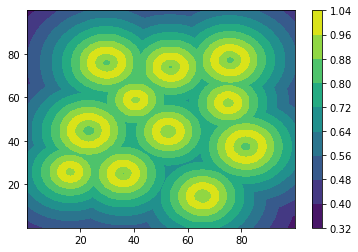

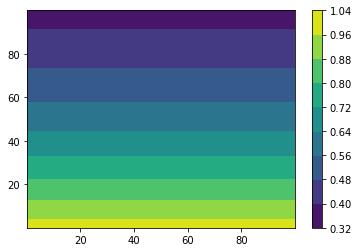

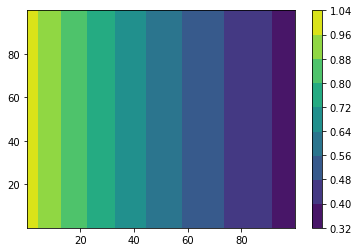

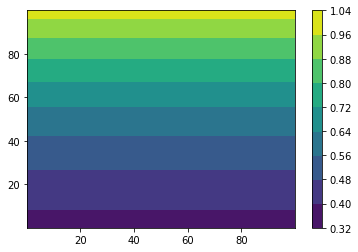

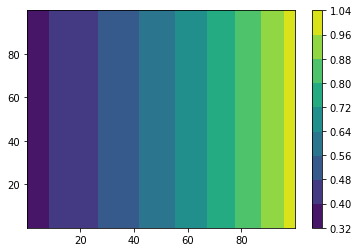

In [17]:
for i in range(geometric_fields.shape[2]):
    plt.figure()
    grid_x, grid_y = np.meshgrid(raster_array.x, raster_array.y)
    plt.contourf(grid_x, grid_y, geometric_fields[:, :, i])
    plt.colorbar()